<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>

# Modeling Hillslopes and Channels with Landlab
The original version of this exercise was donated by Andy Wickert at the University of Minnesota.

<hr>
<small> For instructions on how to run an interactive IPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For tutorials on learning Landlab, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

** What is this notebook? **

This notebook illustrates a landscape evolution model in which the landscape evolves according to the equation:

\begin{equation}
 \frac{\partial z}{\partial t} = -K_\text{sp} A^{m_{sp}} S^{n_{sp}} + K_\text{hs} \frac{\partial^2 z}{\partial x^2} + U
\end{equation}
Here, $K$ are coefficients on the fluvial (_sp_) and hillslope (_hs_) parts of the equation, and $m_{sp}$ and $n_{sp}$ are positive exponents, usually thought to have a ratio, $m_{sp}/n_{sp} \approx 0.5$. $A$ is drainage area and $S$ is the slope of steepest descent ($-\frac{dz}{dx}$) where $x$ is horizontal distance (positive in the downslope direction) and $z$ is elevation. (If slope is negative there is no fluvial erosion.) $U$ is an externally-applied uplift field.

The first term on the right hand side of the equation is the fluvial erosion term, which is also known as the stream power equation. The second term on the right hand side of the equation is elevation changes via linear diffusion, and linear diffusion is one way in which to describe hillslope sediment transport.

** What will you do? **

In this exercise you will modify the code to get a better understanding of how different processes and forces control landscape evolution, landscape form and drainage density (as interpreted from slope-area data). It is expected that you have already learned that basics about fluvial bedrock incision (and the stream power equation) and sediment transport through creep on hillslopes (and the diffusion equation).

Start by sequentially running each code block without changing anything. To run an individual code cell, put the cursor in the cell and type shift-enter, or got to the _Cell_ pulldown menu at the top and choose _Run Cells_. At the end of the notebook you will see the questions that you need to answer by changing parts of the code and rerunning it. 

Remember that you can always go to the _Kernel_ pulldown menu at the top and choose _Restart & Clear Output_ or _Restart & Run All_ if you change things and want to start afresh. If you just change one code block and rerun only that code block, only the parts of the code in that code block will be updated. (E.g. if you change parameters but don't reset the code blocks that initialize run time or topography, then these values will not be reset.)  

** Questions to answer before starting this assignment. **

1. If hillslope diffusivity ($K_{hs}$) is fixed, but fluvial erodibility ($K_{sp}$) increases, what do you think will happen to the total relief and drainage density of a landscape?
2. If fluvial erodibility ($K_{sp}$) is fixed but hillslope diffusivity ($K_{hs}$) increases, what do you think will happen to the total relief and drainage density of a landscape?
3. If parameters stay fixed ($K_{hs}$ and $K_{sp}$), but the uplift rate increases, what do you think will happen to the total relief and drainage density of a landscape?

** Now on to the code... **

First we have to import the parts of Python and Landlab that are needed to run this code. You should not have to change this first code block.

In [1]:
# Code Block 1

import numpy as np
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import StreamPowerEroder, FlowRouter, \
     LinearDiffuser, DepressionFinderAndRouter
from landlab import imshow_grid
from matplotlib import pyplot as plt
#below is to make plots show up in the notebook
%matplotlib inline 

** Now we set parameters **

This part you will need to change for the different exercises. 

Note that Landlab does not impose units, but it assumes that all units are consistent. We will assume that everything is given in _meters_ (m) and _years_ (yr).

In [2]:
# Code Block 2

uplift_rate = 0.001  # [m/yr], initially set at 0.001
K_sp = 1.e-5  # units vary depending on m_sp and n_sp, initially set at 1e-5
m_sp = 0.5 # exponent on drainage area in stream power equation, initially 0.5
n_sp = 1. # exponent on slope in stream power equation, initially 1.
K_hs = 0.5  # [m^2/yr], initially 0.05

** Make a grid. **

This part you may want to change.

In [3]:
# Code Block 3

ncells_side = 150 # number of raster cells on each side, initially 150
dxy  = 50 # side length of a raster model cell, or resolution [m], initially 50

# Below is a raster (square cells) grid, with equal width and height 
mg = RasterModelGrid((ncells_side, ncells_side), dxy)

# Below is a Hexagonal grid (hexagonal cells, 
# with equal width and height (a square)
#mg = HexModelGrid(ncells_side, ncells_side, dxy, shape='rect')

# Below is a hexagonal grid (hexagonal cells), 
# in which the grid is also a hexagon
#mg = HexModelGrid(ncells_side, ncells_side/2, dxy, shape='hex')

Set some variables related to time. 

In [10]:
# Code Block 4

dt = 5000 # time step [yr], initially 5000
total_time = 0 # amount of time the landscape has evolved [yr]
tmax = 1E6  # time for the model loop to run [yr], initially 1e6

t = np.arange(0, tmax, dt) # each of the time steps that the code will run

Here we make the initial grid of elevation. 

In [5]:
# Code Block 5

np.random.seed(0) # seed set to zero so our figures are reproducible
mg_noise = np.random.rand(mg.number_of_nodes)/1000. # intial noise on elevation grid

# set up the elevation on the grid
zr = mg.add_zeros('node', 'topographic__elevation')
zr += mg_noise

Intializing all of the process components that do the work.

In [6]:
# Code Block 6

frr = FlowRouter(mg) # intializing flow routing
spr = StreamPowerEroder(mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0,
                        use_Q=None) #initializing stream power incision
dfn = LinearDiffuser(mg, linear_diffusivity=K_hs, deposit = False) # initializing linear diffusion
#df = DepressionFinderAndRouter(mg) # Initializing the pit finder

Now for the code loop. Note that you can rerun this code block many times, and as long as you don't rerun any of the code boxes above, it will take the already evolved landscape and evolve it even more.

In [14]:
# Code Block 7

for ti in t:
    zr[mg.core_nodes] += uplift_rate*dt # uplift the landscape
    dfn.run_one_step(dt) # diffuse the landscape
    frr.run_one_step() # route flow
    #df.map_depressions()
    spr.run_one_step(dt) # fluvial incision
    total_time += dt # update time keeper
    print(total_time)

1005000
1010000
1015000
1020000
1025000
1030000
1035000
1040000
1045000
1050000
1055000
1060000
1065000
1070000
1075000
1080000
1085000
1090000
1095000
1100000
1105000
1110000
1115000
1120000
1125000
1130000
1135000
1140000
1145000
1150000
1155000
1160000
1165000
1170000
1175000
1180000
1185000
1190000
1195000
1200000
1205000
1210000
1215000
1220000
1225000
1230000
1235000
1240000
1245000
1250000
1255000
1260000
1265000
1270000
1275000
1280000
1285000
1290000
1295000
1300000
1305000
1310000
1315000
1320000
1325000
1330000
1335000
1340000
1345000
1350000
1355000
1360000
1365000
1370000
1375000
1380000
1385000
1390000
1395000
1400000
1405000
1410000
1415000
1420000
1425000
1430000
1435000
1440000
1445000
1450000
1455000
1460000
1465000
1470000
1475000
1480000
1485000
1490000
1495000
1500000
1505000
1510000
1515000
1520000
1525000
1530000
1535000
1540000
1545000
1550000
1555000
1560000
1565000
1570000
1575000
1580000
1585000
1590000
1595000
1600000
1605000
1610000
1615000
1620000
1625000


Plot the topography.

('Maximum elevation is ', 466.09467327652249)


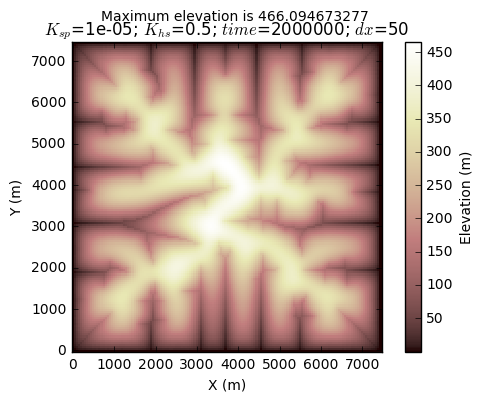

In [15]:
# Code Block 8

plt.figure(1)
imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'),
                var_name='Elevation (m)')
title_text = '$K_{sp}$='+str(K_sp) + '; $K_{hs}$='+str(K_hs) + '; $time$='+str(total_time) + '; $dx$='+str(dxy)
plt.title(title_text)

max_elev = np.max(zr)
suptitle_text = 'Maximum elevation is '+str(max_elev)
plt.suptitle(suptitle_text)

print('Maximum elevation is ', np.max(zr))

Plot the slope and area data at each point (in log-log space).

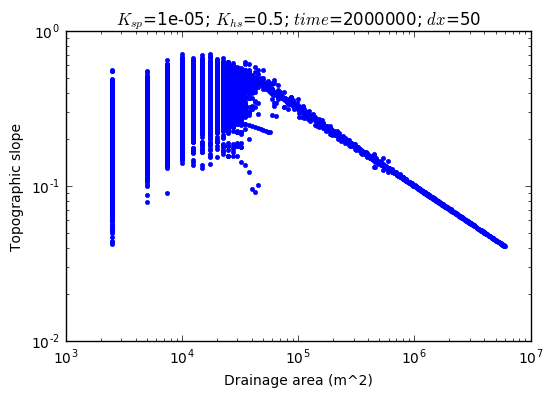

In [16]:
# Code Block 9

plt.figure(2)
indices = np.where(mg.status_at_node[mg.at_node['flow__receiver_node']] == 0)
plt.loglog(mg.at_node['drainage_area'][indices],
           mg.at_node['topographic__steepest_slope'][indices], 'b.')

plt.ylabel('Topographic slope')
plt.xlabel('Drainage area (m^2)')
plt.title(title_text)

Has the landscape reached steady state yet? 


Answer: Not quite. At perfect steady state, there will be no scatter in the fluvial part of the slope-area relationship (given this model set-up).

** What to do. **

Answer the following questions using the code above. All solutions should be typed, and supporting figures (produced using the code) should be embedded in your final document. (Download or screenshoot the figures.) You may want to make other plots with the data you collect using this model. You are free to make those plots using whatever software you choose.

In parts of this exercise you need to work with your classmates. You are encouraged to discuss how to use the model and model results with your classmates, however the write-up that you hand in must be your own work.

1. **Hillslope vs. Fluvial Processes. ** Using the parameters provided in the initial notebook, run the landscape to steady state, or the point at which the topography and the slope-area relationship stop changing (i.e. erosion equals rock uplift). (You can keep rerunning Code Block 7 until steady state is reached. Steady state is reach asymptotically, so exact steady state is less important than very close.) Use the plots of slope and area to estimate where the hillslope–fluvial transition is (or in otherwords, the threshold drainage area for channel heads. There is usually a range of values. You should be consistent in your method to determine drainage density and describe how you determined it in your write-up). Also record the maximum elevation. Now try keeping $K_{sp}$ the same but increase and decrease $K_{hs}$ (change and run Code Block 2, then rerun Code Blocks 6 and 7). How do the maximum elevation and the transition from hillslope to channel change with changes in $K_{hs}$? Now try keeping $K_{hs}$ the same but increase and decrease $K_{sp}$ (change and run Code Block 2, then rerun Code Blocks 6 and 7). How do the maximum elevation and transition from hillslope to channel change with changes in $K_{sp}$? You can work in teams with your classmates so that you can explore more parameter combinations. Produce a relationship between the different values of $K_{sp}$, $K_{hs}$ and the threshold drainage area and maximum elevation. Remember to run all of your different parameter values to steady state before estimating the threshold drainage area and maximum elevation. Describe how the different parameters affect drainage density in words, and how this is seen in the relationship that you generate. You do not have to include plots of every single run, but include plots to illustrate at least three landscapes with different drainage densities.

2. **Uplift and erosion. ** Now, perform a similar set of exercises as you did in exercise 1, but also systematically vary uplift rate (Code Block 2). Work in teams, and each person should choose two combinations of $K_{sp}$ and $K_{hs}$ and three uplift rates (for a total of 6 runs). Make sure the parameter values that you choose do not overlap with your group members. Make sure you document the transition from hillslope to fluvial process (make sure all of the team members are using the same method to determine threshold area for drainage density), and also note the maximum steady-state elevation for each combination of uplift, $K_{sp}$ and $K_{hs}$. Produce relationships to show how the area threshold and maximum elevation change with the different variables. Describe how uplift rate affects drainage density in words, and how this is seen in the relationship that you generate. You do not have to include plots of every single run, but include some plots to illustrate the changes that you describe. (Note whom your group members were in your write-up.)

3. ** Landscapes evolving to steady state. ** Try changing the grid size (Code Block 3) and then rerun all the code blocks sequentially. Keep running the time loop (Code Block 7) until it reaches steady state and record the time it takes to get to steady state. Now trying changing the rock uplift rate (Code Block 2), rerun ALL the code blocks sequentially, and the keep running the time loop (Code Block 7) until the landscape reaches steady state again (record the time). Change the resolution (i.e. the cell size, Code Block 3) and follow the same procedure (rerun everything, then run until steady state). Combine in groups to gather enough model outputs to form relationships between time to steady state and grid size, resolution, or  rock uplift rate. Describe in words how the different parameters and model domain set-ups affect the time to steady state. Describe how this does or does not make sense physically. Include any necessary plots that help you to describe your answers.

4. ** Free-form exploration. ** Try changing the grid type (Code Block 3), grid size (Code Block 3), stream power exponents (Code Block 2), distribution of uplift rate (e.g., what happens if you have just part of the landscape experience uplift, a bit trickier, as uplift in Code Block 2 will need to be changed to an array), etc. Based on what you observe, create a consistent geomorphic history of the system. Creativity is expected here!

5. ** Final reflection. ** Was your initial insight into how parameters would affect the landscape correct? Discuss in less than 5 sentences.